In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product k.csv', parse_dates=['Month-Year'])


In [3]:
sales_k= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_k = sales_k.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_k.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,505010,797644,8355561
1,2019-02-01,521132,823109,8622305
2,2019-03-01,580897,917505,9611137
3,2019-04-01,612559,967514,10134996
4,2019-05-01,550697,869805,9111468


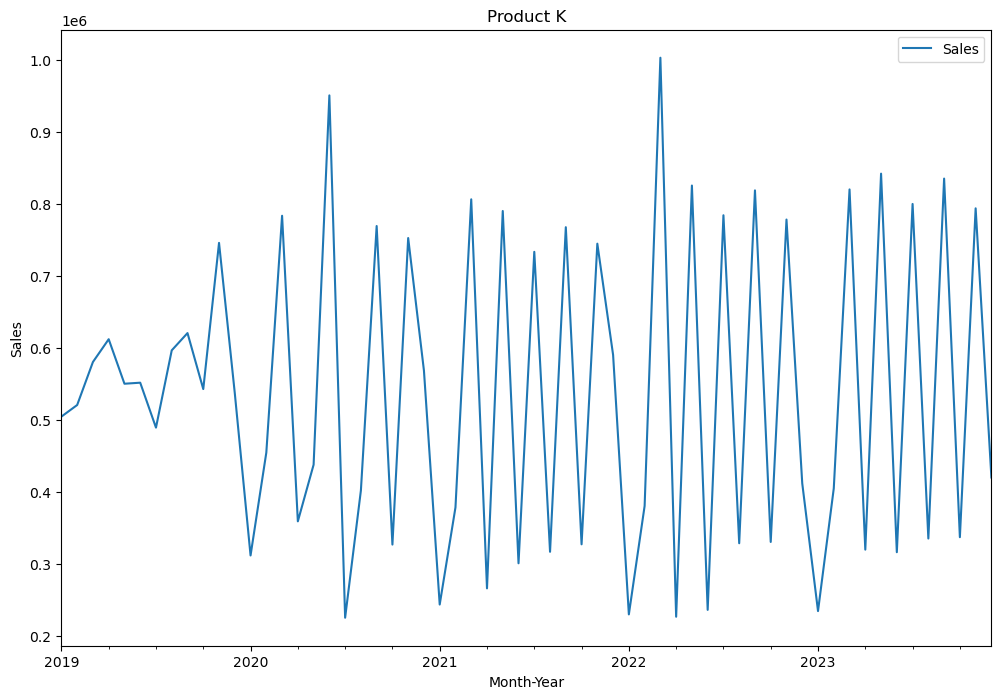

In [5]:
ax = sales_k.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product K')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_k[:54]
test=sales_k[54:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

01:25:29 - cmdstanpy - INFO - Chain [1] start processing
01:25:32 - cmdstanpy - INFO - Chain [1] done processing
01:26:04 - cmdstanpy - INFO - Chain [1] start processing
01:26:04 - cmdstanpy - INFO - Chain [1] done processing
01:26:08 - cmdstanpy - INFO - Chain [1] start processing
01:26:09 - cmdstanpy - INFO - Chain [1] done processing
01:26:12 - cmdstanpy - INFO - Chain [1] start processing
01:26:12 - cmdstanpy - INFO - Chain [1] done processing
01:26:16 - cmdstanpy - INFO - Chain [1] start processing
01:26:19 - cmdstanpy - INFO - Chain [1] done processing
01:26:23 - cmdstanpy - INFO - Chain [1] start processing
01:26:23 - cmdstanpy - INFO - Chain [1] done processing
01:26:27 - cmdstanpy - INFO - Chain [1] start processing
01:26:27 - cmdstanpy - INFO - Chain [1] done processing
01:26:32 - cmdstanpy - INFO - Chain [1] start processing
01:26:33 - cmdstanpy - INFO - Chain [1] done processing
01:26:38 - cmdstanpy - INFO - Chain [1] start processing
01:26:38 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

             rmse  
0   139130.028297  
1   154817.545506  
2    79607.851333  
3    80234.895204  
4    79921.049481  
.. 

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
70,0.500,10.00,additive,77082.821916
39,0.200,0.10,multiplicative,78228.815913
38,0.200,0.10,additive,78240.597751
8,0.001,5.00,additive,78598.807028
20,0.010,5.00,additive,78694.916725
...,...,...,...,...
13,0.010,0.01,multiplicative,152191.062557
25,0.100,0.01,multiplicative,152232.225735
37,0.200,0.01,multiplicative,152283.851113
61,0.500,0.01,multiplicative,152617.331434


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.500, seasonality_prior_scale=10.00, seasonality_mode= 'additive',interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

01:42:56 - cmdstanpy - INFO - Chain [1] start processing
01:42:57 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
len(test)

6

In [13]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [14]:
future_dates['Market Size'] = sales_k['Market Size']
future_dates['Marketing Expense'] = sales_k['Marketing Expense']

In [15]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,797644,8355561
1,2019-02-01,823109,8622305
2,2019-03-01,917505,9611137
3,2019-04-01,967514,10134996
4,2019-05-01,869805,9111468
5,2019-06-01,872080,9135293
6,2019-07-01,773482,8102450
7,2019-08-01,943094,9879188
8,2019-09-01,980970,10275945
9,2019-10-01,1178924,12349572


In [16]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [17]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

In [18]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
54,2023-07-01,804056.594791,736172.406602,875637.423396
55,2023-08-01,335453.223177,268394.610055,402953.975060
56,2023-09-01,831337.282227,768166.656487,903545.336097
57,2023-10-01,525388.287096,459888.685083,589102.717402
58,2023-11-01,688543.672432,620368.102632,759310.112454
59,2023-12-01,351793.889447,284750.212763,423156.467378


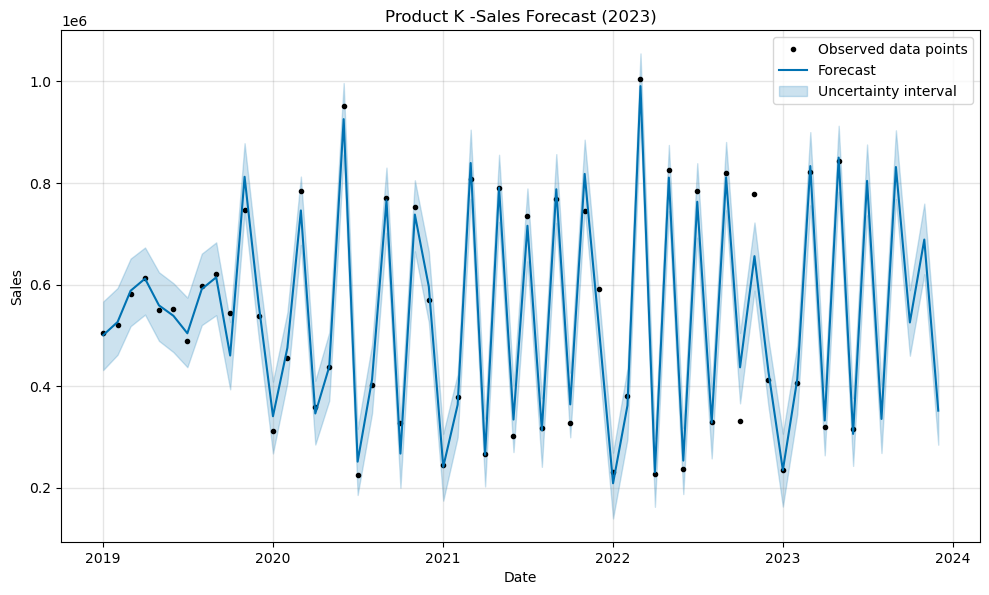

In [19]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product K -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

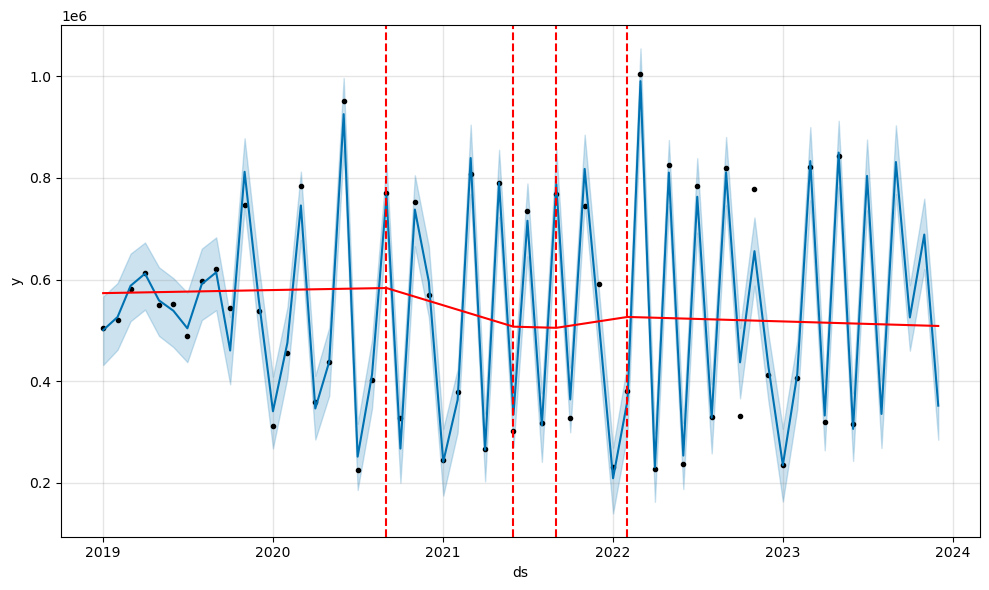

In [20]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

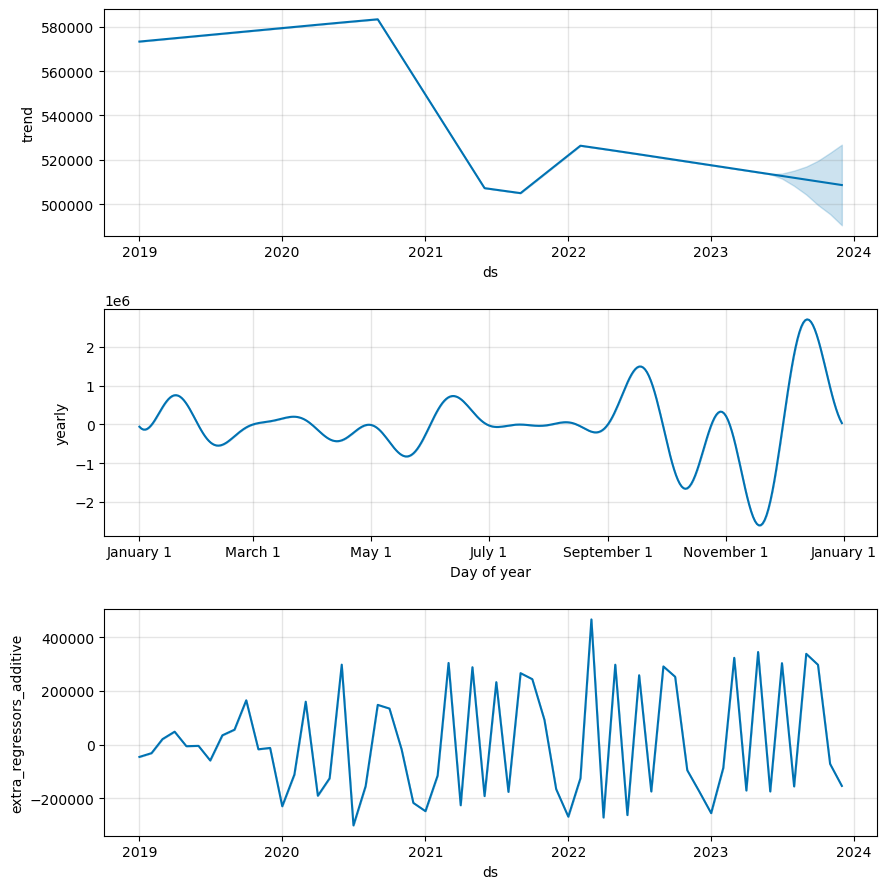

In [21]:
fig2 = model.plot_components(forecast)

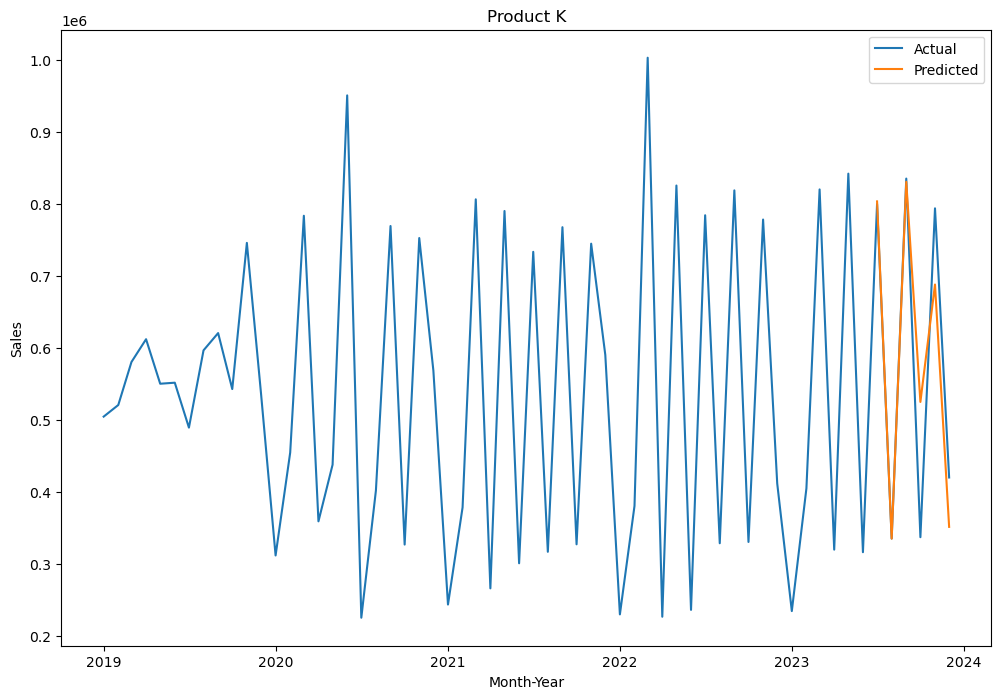

In [22]:
# Reset index of sales_b DataFrame
sales_k_reset_index = sales_k.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_k_reset_index['ds'], sales_k_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product K')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
#model evaluation

In [24]:
pred=forecasted_df['yhat']
test_df=test['y']

In [25]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 61760.302
MAPE - FB PROPHET: 0.144
MSE - FB PROPHET: 8544289147.056
RMSE - FB PROPHET: 92435.324


In [26]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='180 days', parallel="processes")

In [27]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,24 days,6.293513e+08,25086.875631,24481.399393,0.061684,0.061684,0.063887,1.0
1,25 days,1.822389e+08,13499.587902,10418.333736,0.042443,0.042443,0.044219,1.0
2,29 days,4.879184e+08,22088.875506,16509.076276,0.067574,0.067574,0.063437,1.0
3,51 days,8.377243e+08,28943.466477,28849.089944,0.108203,0.108203,0.102391,1.0
4,55 days,3.651972e+08,19110.132436,15875.055191,0.048672,0.048672,0.047042,1.0
5,56 days,4.032570e+08,20081.260323,16574.351912,0.049289,0.049289,0.047611,1.0
6,60 days,1.469362e+09,38332.255917,37192.034128,0.099746,0.099746,0.094911,1.0
7,82 days,3.679296e+09,60657.197465,59287.821172,0.104261,0.104261,0.099049,1.0
8,83 days,2.925142e+09,54084.582065,48812.425603,0.059644,0.059644,0.057381,1.0
9,87 days,9.718861e+08,31175.087955,30735.840026,0.034652,0.034652,0.034021,1.0


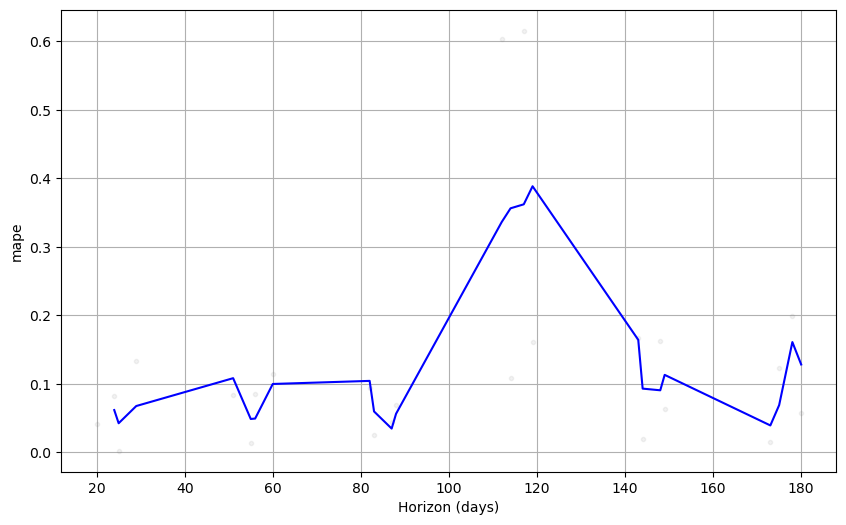

In [28]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [29]:
test_df

54    800485
55    335618
56    835745
57    337462
58    794412
59    420417
Name: y, dtype: int64

In [30]:
pred

54    804056.594791
55    335453.223177
56    831337.282227
57    525388.287096
58    688543.672432
59    351793.889447
Name: yhat, dtype: float64